In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D

from PIL import Image

import skimage.io
import skimage.color
import skimage.exposure
from skimage.color import rgb2gray

from scipy import signal
from scipy.ndimage import sobel, gaussian_filter, maximum_filter, convolve

# Data loader

View 1 resolution: 449x600
View 2 resolution: 449x600


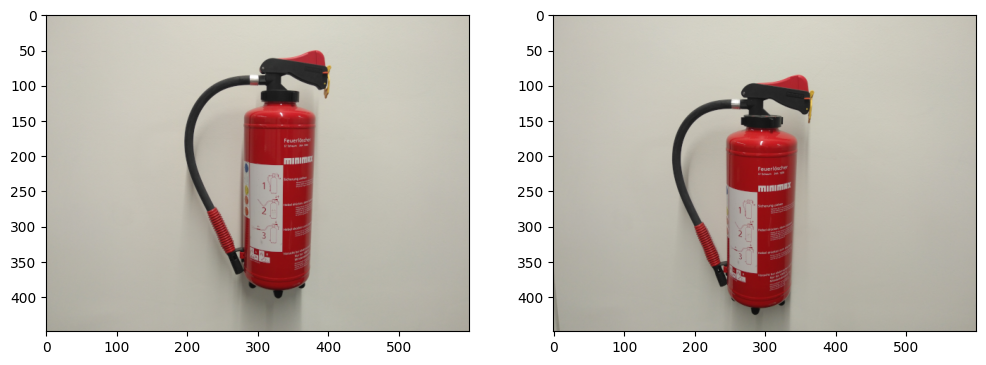

In [38]:
##### Need image database

##### Testing
# Load images and resize
VIEW1 = np.array(Image.open("data/fire-extinguisher/01.png")) / 255
VIEW2 = np.array(Image.open("data/fire-extinguisher/02.png")) / 255

# Check resolution
print(f"View 1 resolution: {VIEW1.shape[0]}x{VIEW1.shape[1]}")
print(f"View 2 resolution: {VIEW2.shape[0]}x{VIEW2.shape[1]}")

# Show both views
_, AXES = plt.subplots(1, 2, figsize=(12, 6))
AXES[0].imshow(VIEW1)
AXES[1].imshow(VIEW2)
plt.show()

# Feature detector

In [39]:
def harris_conner_detector(img, window_size=5, k=0.05, threshold=10):
    """
    This function takes an input image and computes harris corner locations and orientations
    :param img: the image
    :param window_size: size of the window in which we look for corners
    :param k: factor to compute the harris score, usually between 0.04 and 0.06
    :param threshold: Harris scores below this threshold are not considered
    :return: a tuple where the first element is a 2D numpy array of keypoint coordinate pairs
             and the second element is a numpy array of local gradient angle
    """

    # 1. compute image gradients in x and y direction (smooth the image before doing that)  
    smooth_img = gaussian_filter(img, sigma=1)

    I_x = sobel(smooth_img, 0)
    I_y = sobel(smooth_img, 1)

    # 2. compute structure tensor Q
    I_xx = I_x**2
    I_yy = I_y**2
    I_xy = I_x*I_y

    I_xx = gaussian_filter(I_xx, sigma=2)
    I_yy = gaussian_filter(I_yy, sigma=2)
    I_xy = gaussian_filter(I_xy, sigma=2)

    # 3. compute harris score
    det = I_xx*I_yy - I_xy**2
    trace = I_xx + I_yy
    harris_score = det - k*(trace**2)

    # 4. perform non-maximum suppression
    # as maximum_filter change the central elements of window to the highest value in that window
    # => if original harris_score matrix is not the same as max_harris_score_in_window,
    # it is not the maximum value in the window, otherwise it is the maximum when they are equal
    max_harris_score_in_window = maximum_filter(harris_score, size=window_size)

    _points = []
    threshold = threshold/1000 #threshold is too big, bigger than the highest H-score

    for x in range(harris_score.shape[0]):
        for y in range(harris_score.shape[1]):
            if harris_score[x,y] >= threshold and max_harris_score_in_window[x,y] == harris_score[x,y]:
                _points.append([y,x])
    
    # 5. compute angles
    angles = [np.arctan2(I_y[x,y],I_x[x,y]) for [x,y] in _points]

    return (np.array(_points),np.array(angles))

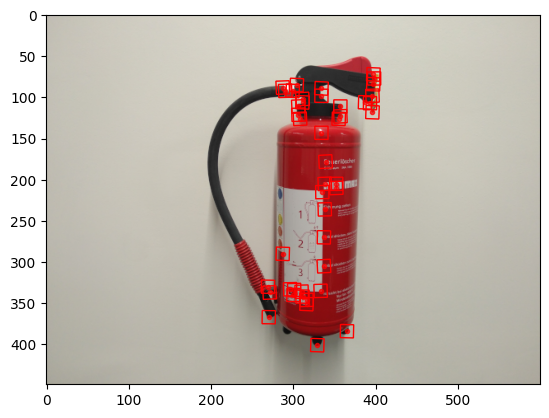

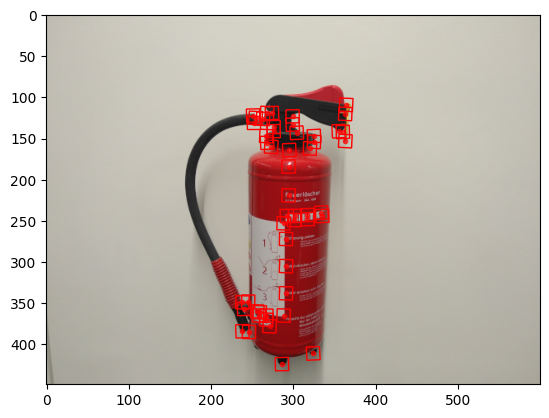

In [40]:
### Show the result
def plot_patches(img, keypoints, angles, patch_size=16):
    """
    :param img: image
    :param keypoints: Numpy array containig the keypoints
    :param rotations: Numpy array of length=len(keypoints) containing
                      the patch rotation
    """
    scales = np.ones(len(keypoints))*patch_size    
    ax = plt.gca()
    ax.imshow(img)
    ax.scatter(POINTS[:, 0], POINTS[:, 1], marker='.', alpha=0.7, color='r')
    for kp, angle, length in zip(keypoints, angles, scales):
        rect = patches.Rectangle(kp - length / 2, length, length, linewidth=1,
                                 edgecolor='r', facecolor='none')
        transform = Affine2D().rotate_deg_around(*kp, angle) + ax.transData
        rect.set_transform(transform)
        ax.add_patch(rect)
        
    plt.show()

## detecting the coner
KEY_POINTS = {}
for i, target_image in  enumerate([rgb2gray(VIEW1), rgb2gray(VIEW2)]):
    POINTS, ANGLES = harris_conner_detector(target_image, window_size=5, threshold=10)
    KEY_POINTS[f"view{i + 1}"] = (POINTS, ANGLES)

## create patches
for i, target_image in  enumerate([VIEW1, VIEW2]):
    POINTS, ANGLES = KEY_POINTS[f"view{i + 1}"]
    plot_patches(target_image, POINTS, ANGLES, patch_size=16)

# Image matching

# Global alignment

# Blending and Compositing

# Output

In [41]:
### General code structure

def stitching_images(img_src, img_des):
    gd_src = rgb2gray(img_src)
    gd_des = rgb2gray(img_des)

    ### TODO: Harris conner detecting and the patches - areas around conners

    ### TODO: SIFT computing the feature description by gradient of each patch
    
    ### TODO: Compute distance matrix based on SIFT of each patch

    ### TODO: Match each patch with from distance matrix above

    ### TODO: Run RANSAC to remove the outline pair of patch

    ### TODO: Composite two images into one

    ### TODO: Normalize the images (e.g. have same brightness levels)

    return [combined_image, Harris, num_inliers, residual]